# Methods - Analyzing CAPTURE Tractography Methodology
Tony Sun, Jon Liu  
February 20, 2017 Deliverable 

### Setting
1. Task: The last stage of the pipeline that Ailey would like us to implement is a tractography element.  Currently, Ailey's lab uses the CAPTURE tractography method - this method can be split up into two parts:  
    1)  Using TrackVis, they find/visualize fiber tracts using its built in methods.
    2)  Using CAPTURE (MATLAB scripts written by the Deisseroth lab), they generate the tractography estimates.  
2. Loss function: We will evaluate loss through a percent-error analysis [ie: observed less expected over expected]. What this entails is after we receive the "true" tractography estimates from labeled data from Ailey for a given region, which could be used as a comparison point for the tractography estimates from CAPTURE.
3. Statistical goal: Minimize error between "true" tractography results and estimated results.
4. Desiderata: We desire a tractography process that:  
    i.  Delineate individual fiber tracts from diffusion images  
    ii. Can be easily integrated with our existing Python packages  
    iii. Is fast, computationally-speaking  
    iv. Is easy to use  


### Concepts

The CAPTURE methods are similar to existing MRI-based diffusion tensor imaging.  In layman's terms, given an image with axons projecting from some regions to other regions, we're interested in seeing/calculating the 3D trajectories of the bundles.  In order to do so, MRI-based diffusion tensor imaging uses the fact that the diffusion of water during MRI imaging is different for different tissue types.  Water diffuses along the path of the fibers, so tracing the trajectory of the water along the fiber would give a rough estimate to the fiber tracts in the brain.

For the CLARITY data, CAPTURE works in a similar fashion.  I quote:  

"The tractography algorithm propagates/streamlines from a “seed” region through a vector field of voxel-wise principal fiber orientations and terminates if a streamline makes a sharp turn (angles larger than a prescribed threshold αthresh) or ventures outside of the masked region. For each voxel, the principal fiber orientation was estimated from a structure tensor, which was computed using the image intensity gradients (as a marker of the edges of fiber tracts) within a local neighborhood of the voxel."  

In layman's terms, again, the gradient of the image data was taken (by finding the partial derivatives using their MATLAB scripts).  From there, they could estimate the "next direction" that the fiber moved in, since the value of the gradient gives the "borders" of the voxel in each direction.  As long as the gradient in a certain direction was less than some threshold (for a sharp turn), the fiber was said to continue along said pathway.

### Diffusion Toolkit/TrackVis Analysis

Diffusion toolkit - used to generate trk (track files) for TrackVis.  Does so using either DTI method, HARDI/Q-BALL method, with some given way to calculate gradients.  The MATLAB code provided by CAPTURE effectively skips the GUI interface for the Diffusion toolkit - the existing workflow uses calculates a "structure tensor" which is then used to generate a .trk file.  It then directly uses the command line to run the Diffusion Toolkit part that traces a given tract.

**INPUT:** takes in NIFTI files (although it threw an error with only raw .nii we had stored)  
**OUTPUT:** trk (track file) for use with TrackVis  

TrackVis toolkit - used to visualize brain images.  

**INPUT:** trk (track file)  
**OUTPUT:** visualizations of tracks in brain images  


### MATLAB Pseudocode Analysis

Analysis on: https://github.com/ChristophKirst/ClearMap/blob/master/ClearMap/ImageProcessing/IlastikClassification.py  
[ClearMap Ilastik Classification Script]  

From the analysis of the code, the MATLAB script effectively replaces some parts of the Diffusion Toolkit process by doing three different things:  
1.  classifyPixel  
2.  classifyCells  

![classifyPixel](classifyPixel.png)
![classifyCells](classifyCell.png)


### MATLAB Writeup Analysis
Since the ClearMap Ilastik module just runs an Ilastik pixel classifier, the ClearMap Ilastik part's methodology is no different than what we did in the past in generating 3D pixel classifiers in Ilastik.  As a brief refresher on what happened then, the last attempts made using Ilastik on Ailey's data proved inconclusive.  I went over this in detail with Greg on 11/4 at office hours - we realized that the pixel classifier that I was making was failing because the Aut data that we had access to wasn't high enough resolution to distinguish cell bodies (the image quality was at a macroscopic level).  We were able to follow the ndio tutorials to select a subset of the image/download some of the data, but we were only able to get the resolution 5 image data.

Note, however, that while the ClearMap Ilastik method just runs Ilastik, the Ilastik method is incorporated into the other parts of the ClearMap pipeline.  The pipeline takes the generated pixel probabilities/class labels and runs additional processing steps (eg: there are additional parameters, like removing background processing, etc). The ClearMap process recommends at LEAST 32 gigabytes of RAM for processing (it recommends 128 GB) -- since Cortex only has 3 GB of free RAM, and since the my deliverable is mainly to analyze the efficacy of the Ilastik pixel module, I used the desktop version of Ilastik on my computer.

### Results

**Where it should work well:**
The MATLAB tensor script should work well on CLARITY data, which is what it's written for.

**Where it should work poorly:**
Obviously, ??

### Analysis

In [1]:
%matplotlib inline

import os
import numpy as np

In [4]:
from PIL import Image
myImage = Image.open("goodExample.png");

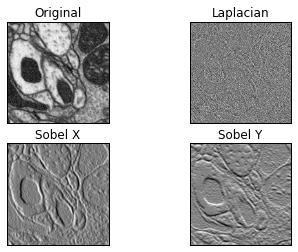

In [6]:
## Compute image gradients using Python CV2
## Note that the image gradients are used to show the "boundaries" of fiber tracts.
## We didn't have any fiber tract TIFFs, so I used an EM data example to show that it's capable
## of finding cell boundaries.

import sys

sys.path.append('/usr/local/lib/python2.7/site-packages')

import cv2
from matplotlib import pyplot as plt

img = cv2.imread('goodExample.png',0)

laplacian = cv2.Laplacian(img,cv2.CV_64F)
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)

plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

plt.show()

### How well did it work?
We need:  
1)  Adequate working TIFF stacks (our current TIFF stack doesn't have tractography)  
2)  File format structure use in CAPTURE (confused as to why it has multiple channels, ie: red, green, also what do we do about the brain masking/seed masking?)  